<a href="https://colab.research.google.com/github/MayXiao/Uva_projects/blob/main/forecasting_group_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [234]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
# Import widgets
from ipywidgets import widgets, interactive, interact
import ipywidgets as widgets
from IPython.display import display

### Loading dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
path = '/content/drive/MyDrive/F_group_project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
cal_dtypes = {
    'wm_yr_wk': np.uint16,
    'weekday': 'category',
    'wday': 'category',
    'month': 'category',
    'year': 'category',    
    'event_name_1': 'category',
    'event_type_1': 'category',
    'event_name_2': 'category',
    'event_type_2': 'category',
    'snap_TX': np.uint8
}
cal = pd.read_csv(path + 'calendar_afcs2022.csv', 
                  dtype=cal_dtypes, 
                  usecols=list(cal_dtypes.keys()) + ['date'], 
                  parse_dates=['date'])
event_cols = [k for k in cal_dtypes if k.startswith('event')]
for col in event_cols:
    cal[col] = cal[col].cat.add_categories('nan').fillna('nan')
cal.insert(0, 'd', range(1, 1 + len(cal)))
cal.d = cal.d.astype('str')

In [10]:
cal.head()

,d,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX
0,1,2011-01-29,11101,Saturday,1,1,2011,nan,nan,nan,nan,0
1,2,2011-01-30,11101,Sunday,2,1,2011,nan,nan,nan,nan,0
2,3,2011-01-31,11101,Monday,3,1,2011,nan,nan,nan,nan,0
3,4,2011-02-01,11101,Tuesday,4,2,2011,nan,nan,nan,nan,1
4,5,2011-02-02,11101,Wednesday,5,2,2011,nan,nan,nan,nan,0


In [42]:
print("Number of Rows And Column in Calander_Data ",cal.shape)

Number of Rows And Column in Calander_Data  (1969, 12)


In [11]:
prices_dtypes = {
    'store_id': 'category',
    'item_id': 'category',
    'wm_yr_wk': np.uint16,
    'sell_price': np.float32
}
prices = pd.read_csv(path + 'sell_prices_afcs2022.csv', dtype=prices_dtypes)
prices['val'] = 'validation'
prices['item_id'] = prices[['item_id', 'store_id','val']].agg('_'.join, axis=1)
prices.drop(['store_id','val'], axis=1, inplace=True)

In [12]:
prices.head()

,item_id,wm_yr_wk,sell_price
0,FOODS_3_001_TX_3_validation,11101,2.28
1,FOODS_3_001_TX_3_validation,11102,2.28
2,FOODS_3_001_TX_3_validation,11103,2.28
3,FOODS_3_001_TX_3_validation,11104,2.28
4,FOODS_3_001_TX_3_validation,11105,2.28


In [44]:
print("Number of Rows And Column in Price_Data ",prices.shape)

Number of Rows And Column in Price_Data  (185260, 3)


In [74]:
sales_train_dtypes = {
    'id': 'category',
    **{f'd_{i}': np.float32 for i in range(1942)}
}
sales_train = pd.read_csv(
    path + 'sales_train_validation_afcs2022.csv',
    dtype=sales_train_dtypes
)

In [75]:
sales_train.head()

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,FOODS_3_001_TX_3_validation,0.0,2.0,1.0,3.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,2.0,0.0
1,FOODS_3_002_TX_3_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FOODS_3_003_TX_3_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,FOODS_3_004_TX_3_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FOODS_3_005_TX_3_validation,0.0,1.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,...,0.0,4.0,2.0,1.0,1.0,0.0,1.0,0.0,4.0,0.0


In [58]:
print("Number of Rows And Column in Sales Train Data ",sales_train.shape)

Number of Rows And Column in Sales Train Data  (823, 1914)


To join sales data on calender and price, using pd.melt to swap row (d_1, d_2, ...) to columns d

In [64]:
sales_train_trans = sales_train.melt(
  id_vars=['id'],
  var_name='d',
  value_name='y'
)
sales_train_trans['train1_val2_test0'] = 1

In [65]:
sales_train_trans.head()

,id,d,y,train1_val2_test0
0,FOODS_3_001_TX_3_validation,d_1,0.0,1
1,FOODS_3_002_TX_3_validation,d_1,0.0,1
2,FOODS_3_003_TX_3_validation,d_1,0.0,1
3,FOODS_3_004_TX_3_validation,d_1,0.0,1
4,FOODS_3_005_TX_3_validation,d_1,0.0,1


In [57]:
sales_val = pd.read_csv(
    path + 'sales_test_validation_afcs2022.csv',
    dtype=sales_dtypes,
)

In [66]:
sales_val_trans = sales_val.melt(
    id_vars=['id'],
    var_name='d',
    value_name='y'
)
sales_val_trans['train1_val2_test0'] = 2

In [67]:
sales_val_trans.head()

,id,d,y,train1_val2_test0
0,FOODS_3_001_TX_3_validation,d_1914,1.0,2
1,FOODS_3_002_TX_3_validation,d_1914,0.0,2
2,FOODS_3_003_TX_3_validation,d_1914,0.0,2
3,FOODS_3_004_TX_3_validation,d_1914,0.0,2
4,FOODS_3_005_TX_3_validation,d_1914,1.0,2


In [76]:
sales_test_dtypes = {
    'id': 'category',
    **{f'F_{i}': np.float32 for i in range(29)}
}

sales_test = pd.read_csv(
    path + 'sample_submission_afcs2022.csv',
    dtype=sales_test_dtypes,
)

In [77]:
sales_test.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_3_001_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,FOODS_3_002_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,FOODS_3_003_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,FOODS_3_004_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,FOODS_3_005_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
new_cols = dict(zip(sales_test.columns[1:], ['d_' + str(x) for x in range(1942,1942+29)]))
sales_test.rename(columns= new_cols, inplace=True)

In [92]:
sales_test.head()

,id,d_1942,d_1943,d_1944,d_1945,d_1946,d_1947,d_1948,d_1949,d_1950,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,FOODS_3_001_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,FOODS_3_002_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,FOODS_3_003_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,FOODS_3_004_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,FOODS_3_005_TX_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
sales_test_trans = sales_test.melt(
    id_vars=['id'],
    var_name='d',
    value_name='y'
)
sales_test_trans['train1_val2_test0'] = 0

In [94]:
sales_test_trans.head()

,id,d,y,train1_val2_test0
0,FOODS_3_001_TX_3_validation,d_1942,0,0
1,FOODS_3_002_TX_3_validation,d_1942,0,0
2,FOODS_3_003_TX_3_validation,d_1942,0,0
3,FOODS_3_004_TX_3_validation,d_1942,0,0
4,FOODS_3_005_TX_3_validation,d_1942,0,0


concatenate train, valid and test datasets for future modeling

In [123]:
sale_all = pd.concat([sales_train_trans,sales_val_trans,sales_test_trans],ignore_index=True)

In [124]:
sale_all.head()

,id,d,y,train1_val2_test0
0,FOODS_3_001_TX_3_validation,d_1,0.0,1
1,FOODS_3_002_TX_3_validation,d_1,0.0,1
2,FOODS_3_003_TX_3_validation,d_1,0.0,1
3,FOODS_3_004_TX_3_validation,d_1,0.0,1
4,FOODS_3_005_TX_3_validation,d_1,0.0,1


In [125]:
print("Number of Rows And Column in Transformed Sales Data ",sale_all.shape)

Number of Rows And Column in Transformed Sales Data  (1620487, 4)


In [126]:
%%time
print(sale_all.shape[0])
sale_all['date_idx'] = sale_all['d'].str.replace('d_', '').astype('int32')
sale_all.rename(columns={'id':'item_id','d':'d0','date_idx':'d'}, inplace=True)
print(sale_all.shape[0])

1620487
1620487
CPU times: user 1.26 s, sys: 83.5 ms, total: 1.35 s
Wall time: 1.35 s


In [127]:
sale_all.head()

,item_id,d0,y,train1_val2_test0,d
0,FOODS_3_001_TX_3_validation,d_1,0.0,1,1
1,FOODS_3_002_TX_3_validation,d_1,0.0,1,1
2,FOODS_3_003_TX_3_validation,d_1,0.0,1,1
3,FOODS_3_004_TX_3_validation,d_1,0.0,1,1
4,FOODS_3_005_TX_3_validation,d_1,0.0,1,1


In [128]:
sale_all.tail()

,item_id,d0,y,train1_val2_test0,d
1620482,FOODS_3_823_TX_3_validation,d_1969,0.0,0,1969
1620483,FOODS_3_824_TX_3_validation,d_1969,0.0,0,1969
1620484,FOODS_3_825_TX_3_validation,d_1969,0.0,0,1969
1620485,FOODS_3_826_TX_3_validation,d_1969,0.0,0,1969
1620486,FOODS_3_827_TX_3_validation,d_1969,0.0,0,1969


Merge calender, prices and sales train into one dataset 

In [131]:
sale_all['d'] = sale_all['d'].astype(str)
sale_all = sale_all.merge(cal, on=['d'])

In [132]:
sale_all = sale_all.merge(prices, on=['item_id','wm_yr_wk'])
sale_all = sale_all.drop(columns=['d0', 'wm_yr_wk'])

In [233]:
sale_all.head(5)

,item_id,y,train1_val2_test0,d,date,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX,sell_price
0,FOODS_3_001_TX_3_validation,0.0,1,1,2011-01-29,Saturday,1,1,2011,nan,nan,nan,nan,0,2.28
1,FOODS_3_001_TX_3_validation,2.0,1,2,2011-01-30,Sunday,2,1,2011,nan,nan,nan,nan,0,2.28
2,FOODS_3_001_TX_3_validation,1.0,1,3,2011-01-31,Monday,3,1,2011,nan,nan,nan,nan,0,2.28
3,FOODS_3_001_TX_3_validation,3.0,1,4,2011-02-01,Tuesday,4,2,2011,nan,nan,nan,nan,1,2.28
4,FOODS_3_001_TX_3_validation,0.0,1,5,2011-02-02,Wednesday,5,2,2011,nan,nan,nan,nan,0,2.28


In [134]:
sale_all.memory_usage().sum()

78857737

In [135]:
print("Number of Rows And Column in Summary Data ",sale_all.shape)

Number of Rows And Column in Summary Data  (1292705, 15)


### EDA

In [260]:
ids = sorted(sale_all['item_id'].unique())

series_ids = widgets.Dropdown(
    options=ids,
    value=ids[0],
    description='item_ids:'
)

def plot_data(series_ids):
    df = sale_all.loc[(sale_all['item_id'] == series_ids) & (sale_all['train1_val2_test0']==1) ].set_index('date')
    df['y'].plot(figsize=(18, 7), lw=1, marker='*',label='sales')
    df['y'].rolling(7).mean().plot(figsize=(18, 7), lw=1, marker='o', color='orange',label='7days_avg_sales')
    df['sell_price'].plot(figsize=(18, 7), lw=3, color='green',label='price',)
    plt.axhline(df['y'].values.mean(), lw=3, color='red', label='total_avg_sales')
    plt.grid(color='white', linestyle='-', linewidth=1)
    plt.legend()
    plt.title('Interactice item sales')

In [261]:
w = interactive(
    plot_data,
    series_ids=series_ids
)
display(w)

interactive(children=(Dropdown(description='item_ids:', options=('FOODS_3_001_TX_3_validation', 'FOODS_3_002_T…

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


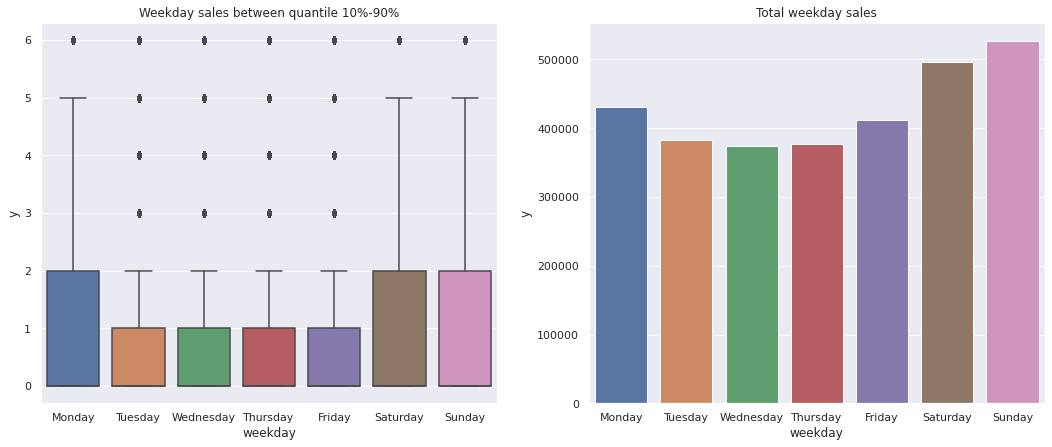

In [308]:
fig, ax = plt.subplots(1,2, figsize=(18, 7))

ax1 = sns.boxplot(data=sale_all[(sale_all['train1_val2_test0']==1) & \
                          (sale_all.y <= sale_all.y.quantile(0.9)) & \
                          (sale_all.y >= sale_all.y.quantile(0.1))], x='weekday',  y='y', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday'],ax=ax[0])
ax1.title.set_text('Weekday sales between quantile 10%-90%')

train = sale_all[sale_all['train1_val2_test0']==1]
train_agg = train.groupby('weekday')['y'].sum().reset_index()
ax2 = sns.barplot(train_agg.weekday,train_agg.y, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday'],ax=ax[1])
ax2.title.set_text('Total weekday sales')
plt.show()

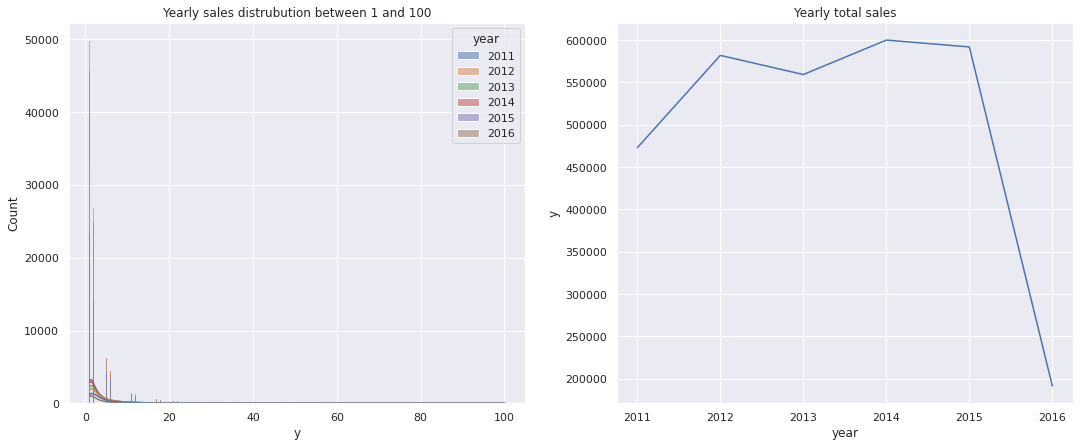

In [359]:
fig, ax = plt.subplots(1,2, figsize=(18, 7))
train_sub = train[(train['y']<=100) & (train['y']>0)]
ax1 = sns.histplot(data = train_sub,x='y', hue='year',kde=True,ax=ax[0])
ax1.title.set_text('Yearly sales distrubution between 1 and 100')

train_plot = train.groupby('year')['y'].sum().reset_index()
ax2 = sns.lineplot(x=train_plot['year'],y=train_plot['y'],ax=ax[1])
ax2.title.set_text('Yearly total sales')
plt.show()

In [307]:

sell_price

AttributeError: ignored